#### This notebook adds the following to the workflow:
- GridSearch for hyperparameter tuning on Random Forest and Decision Tree models
- Important Features on Random Forest with hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from ipywidgets import interactive, FloatSlider
import imblearn.over_sampling

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve 

%matplotlib inline

In [2]:
data = pd.read_csv('/Users/jennihawk/Documents/Data Science/Classification/Churn Project/Models/chatr_clean.csv')

In [3]:
data.shape

(7032, 32)

### Train - Test Setup
- Utilize Stratify Argument

In [4]:
features_in = ['SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'InternetService_Fiber', 'InternetService_No',
       'Contract_One_Year', 'Contract_Two_year', 'PaymentMethod_Crcard',
       'PaymentMethod_Electr_Check', 'PaymentMethod_Mailed_check',
       'MultipleLines_No_phone_serv', 'MultipleLines_Yes', 'Dependents_Yes',
       'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'OnlineSecurity_No_internet_serv', 'OnlineSecurity_Yes',
       'OnlineBackup_No_Internet_Serv', 'OnlineBackup_Yes',
       'DeviceProtection_No_internet_serv', 'DeviceProtection_Yes',
       'TechSupport_No_internet_serv', 'TechSupport_Yes',
       'StreamingTV_No_internet_serv', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_serv', 'StreamingMovies_Yes',
       'PaperlessBilling_Yes']

y = data['Churn_Yes']
X = data[features_in]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5625, 30)
(1407, 30)
(5625,)
(1407,)


### Class Imbalance
Average rate of churn on target columm

In [5]:
np.mean(y_train)

0.2657777777777778

### Setup Oversampling
- 3x positive samples. Rationale: We have 3 to 1 ratio of negative to positive observations. 
- Cross validation confirmed choice. 

In [6]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 3, 0 : n_neg} 

# randomly oversample positive samples
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

#use the fit_sample method to create the dataset with a desired proportion
#the variables X_tr_rs, y_tr_rs hold the training data with the extra samples we just created
X_tr_oversample, y_tr_oversample = ROS.fit_resample(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (4485) in class 1 will be larger than the number of samples in the majority class (class #0 -> 4130)
  warnings.warn(


### Oversampling Cross Validation - Determine how much to increase sample size 
- cross validation strategy for any parameter you want to tune
- here we're doing cross validation on the oversampling to select which number would be best to increase the oversampling. The winner is 3. We're not gaining anything more with higher number. 
- calling cv=10 will stratify behind the scenes

In [7]:
# n_pos = np.sum(y_train == 1)
# n_neg = np.sum(y_train == 0)


# # search for an optimal value 
# oversample_range = [1,2,3,4,5,6]
# oversample_acc_scores = []
# oversample_rec_scores = []
# for oversample_weight in oversample_range:
#     # oversample your data
#     ratio = {1 : n_pos * oversample_weight, 0 : n_neg} 
#     # randomly oversample positive samples: create 4x as many 
#     ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42)

#     #use the fit_sample method to create the dataset with a desired proportion
#     #the variables X_tr_rs, y_tr_rs hold the training data with the extra samples we just created
#     X_tr_oversample, y_tr_oversample = ROS.fit_resample(X_train, y_train)
    
#     # cross validate it
#     d_tree = DecisionTreeClassifier()
#     acc_scores = cross_val_score(d_tree, X_tr_oversample, y_tr_oversample, cv=10, scoring='accuracy')
#     rec_scores = cross_val_score(d_tree, X_tr_oversample, y_tr_oversample, cv=10, scoring='recall')
#     oversample_acc_scores.append(acc_scores.mean())
#     oversample_rec_scores.append(rec_scores.mean())


# print("Oversample Recall Scores")
# print(list(zip(oversample_range, oversample_rec_scores)))
# print("Oversample Accuracy Scores")
# print(list(zip(oversample_range, oversample_acc_scores)))

### Decision Tree

##### Model Setup

In [8]:
#scaled data to have apples to apples comparison with logistic regression
tree_pipe = Pipeline([('scaler', StandardScaler()), ('DecTree', DecisionTreeClassifier())])

In [9]:
#Fit Decision Tree Model to Training Data
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('DecTree', DecisionTreeClassifier())])

#### Hard Class Predictions - No Oversample Train Data

In [10]:
#predict churn / not churn

In [11]:
y_pred = tree_pipe.predict(X_test)

#### Setup up Oversample on Decision Tree Model

In [12]:
oversamp_tree_pipe = Pipeline([('scaler', StandardScaler()), ('DecTree', DecisionTreeClassifier())])

#### Fit the decision tree oversample model

In [13]:
#'X_tr_oversample', 'y_tr_oversample' hold the training data that contains the extra samples
oversamp_tree_pipe.fit(X_tr_oversample, y_tr_oversample)

Pipeline(steps=[('scaler', StandardScaler()),
                ('DecTree', DecisionTreeClassifier())])

#### Hard Class Predictions based on oversampling training data

In [14]:
#we keep same X_test
y_pred_oversamp_tree = oversamp_tree_pipe.predict(X_test)

### Random Forest - Setup Oversample
- Selects random samples from a given dataset
- Constructs a decision tree for each sample and get a prediction result from each decision tree
- Perform a vote for each predicted result
- Select the prediction result with the most votes as the final prediction

In [15]:
#estimators = number of trees in the forest - use default 100
randforest_oversamp = Pipeline([('scaler', StandardScaler()), ('RandForest', RandomForestClassifier(n_estimators=100))])

In [16]:
#fit model on oversample train data
randforest_oversamp.fit(X_tr_oversample, y_tr_oversample)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandForest', RandomForestClassifier())])

#### Random Forest - Hard Class Predictions for Oversample 

In [17]:
y_pred_randfor_oversamp = randforest_oversamp.predict(X_test)

### Hyperparameter tuning on Random Forest - takes a few hours to run
- n_estimators and max_features

In [52]:
#setup separate initialization because pipeline doesn't work with gridsearch
#Don't need to scale featuers for Random Forest
rf = RandomForestClassifier()

In [53]:
#random forest try n_estimators (number of trees) and max_features
# define the parameter values that should be searched
estimator_range = list(range(90, 120))
print(estimator_range)

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


In [54]:
# input for max_features
feature_range = list(range(4, 31))
print(feature_range)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [55]:
# makes sense multiple paramters. Test combinations. 
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators = estimator_range, max_features = feature_range)
print(param_grid)

{'n_estimators': [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], 'max_features': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [56]:
# instantiate the grid
# cv: when binary knows to stratify. 
# 10 fold validation on each combination
grid = GridSearchCV(rf, param_grid, cv=10, scoring='recall')

In [57]:
grid

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_features': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                          15, 16, 17, 18, 19, 20, 21, 22, 23,
                                          24, 25, 26, 27, 28, 29, 30],
                         'n_estimators': [90, 91, 92, 93, 94, 95, 96, 97, 98,
                                          99, 100, 101, 102, 103, 104, 105, 106,
                                          107, 108, 109, 110, 111, 112, 113,
                                          114, 115, 116, 117, 118, 119]},
             scoring='recall')

In [58]:
grid.fit(X_tr_oversample, y_tr_oversample)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_features': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                          15, 16, 17, 18, 19, 20, 21, 22, 23,
                                          24, 25, 26, 27, 28, 29, 30],
                         'n_estimators': [90, 91, 92, 93, 94, 95, 96, 97, 98,
                                          99, 100, 101, 102, 103, 104, 105, 106,
                                          107, 108, 109, 110, 111, 112, 113,
                                          114, 115, 116, 117, 118, 119]},
             scoring='recall')

In [59]:
# view the complete results
grid.cv_results_

{'mean_fit_time': array([0.55791745, 0.56883359, 0.57255456, 0.57739966, 0.57264984,
        0.57996521, 0.58897088, 0.59649842, 0.60047808, 0.60588887,
        0.61265128, 0.61673999, 0.62721324, 0.62672853, 0.63740308,
        0.64077201, 0.65038612, 0.657301  , 0.66711426, 0.67656691,
        0.68154376, 0.6756052 , 0.68932054, 0.68957467, 0.72493181,
        0.73077927, 0.74902952, 0.72434752, 0.74115789, 0.74058909,
        0.60100064, 0.61480963, 0.63060315, 0.62337866, 0.63641267,
        0.65885556, 0.66188407, 0.67688377, 0.66898341, 0.67912121,
        0.67286041, 0.68276021, 0.7004873 , 0.70245326, 0.71070263,
        0.73574483, 0.73055391, 0.71772509, 0.72343662, 0.73762951,
        0.74128389, 0.78561645, 0.75062308, 0.76207826, 0.76394436,
        0.78811977, 0.82468531, 0.78586643, 0.80883992, 0.80865743,
        0.6734997 , 0.68549469, 0.67296634, 0.68580451, 0.7004837 ,
        0.69271502, 0.74088595, 0.72039418, 0.71044996, 0.76450272,
        0.72955825, 0.73616133,

#### Results Random Forest Oversampled, Hyperparameters Tuned - TRAINING DATA
- 'Best score' is recall per grid setup

In [61]:
# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'max_features': 23, 'n_estimators': 119}
Best estimator:  RandomForestClassifier(max_features=23, n_estimators=119)
Best score:  0.9781722279669106


#### Results Random Forest, Hyperparameters Tuned - TEST DATA

In [63]:
best_frst = grid.best_estimator_
#Recall score
best_frst.score(X_test,y_test)

0.7654584221748401

#### Feature Importances - Random Forest, Hyperparameters Tuned - TEST DATA

In [69]:
best_frst2 = grid.best_estimator_.feature_importances_

In [70]:
best_frst2

array([0.01510312, 0.13616748, 0.17320207, 0.17688613, 0.05655724,
       0.00175678, 0.07715241, 0.12447417, 0.01210084, 0.01952235,
       0.01167957, 0.00347991, 0.01193257, 0.01761307, 0.02373515,
       0.0180071 , 0.00373329, 0.00203877, 0.01509063, 0.00148792,
       0.01650353, 0.00197914, 0.01265856, 0.00288352, 0.01519472,
       0.00214851, 0.01065799, 0.00190753, 0.01395262, 0.0203933 ])

#### Get Feature Names, Chart Top 15 Important Features
Random Forest, Hyperparameters Tuned - TEST DATA

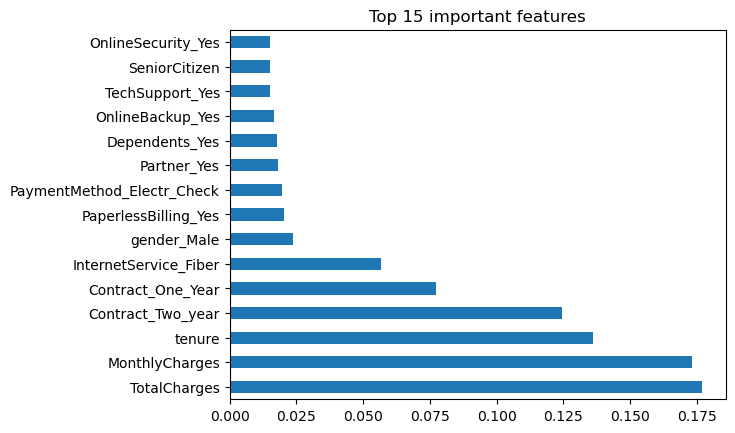

In [73]:
feat_importances = pd.Series(best_frst2, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
# #plt.savefig("RF_FeaturesImg.png", format="png", dpi=300)
plt.show()

### Hyperparameter tuning on Decision Tree
- decision tree try min_samples_leaf: minimum number of samples required to be at a leaf node.
- max_depth: how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. 
- How to use pipeline with grid search https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python

In [28]:
#setup separate initialization because pipeline wasn't working with gridsearch
#Don't need to scale features for Random Forest
decision_tree = DecisionTreeClassifier()

In [29]:
# define the parameter values that should be searched
leaf_range = list(range(1, 31))
print(leaf_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [30]:
# input for max_depth, default is 1
maxdepth_range = list(range(1, 13))
print(maxdepth_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [31]:
# makes sense multiple paramters. Test combinations. 
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(min_samples_leaf = leaf_range, max_depth = maxdepth_range)
print(param_grid)

{'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}


In [32]:
# instantiate the grid
# knows to strategy - binary knows to stratify. 
# 10 fold validation on each combination
tree_grid = GridSearchCV(decision_tree, param_grid, cv=10, scoring='recall')

In [33]:
tree_grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]},
             scoring='recall')

In [34]:
tree_grid.fit(X_tr_oversample, y_tr_oversample)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]},
             scoring='recall')

In [35]:
tree_grid.cv_results_

{'mean_fit_time': array([0.007196  , 0.00696399, 0.00703022, 0.00690753, 0.00699799,
        0.00693483, 0.00691118, 0.00694273, 0.0069015 , 0.00686185,
        0.00718951, 0.00685618, 0.00708573, 0.00690837, 0.00681381,
        0.00689418, 0.00693874, 0.00693102, 0.00689647, 0.00701437,
        0.00690496, 0.00691266, 0.0069989 , 0.00694668, 0.00683601,
        0.00689886, 0.00688448, 0.00685468, 0.0068362 , 0.00710099,
        0.00993381, 0.01005428, 0.01003795, 0.00999098, 0.01037128,
        0.01099086, 0.01039925, 0.01023431, 0.01021543, 0.01026349,
        0.01023617, 0.01014199, 0.01045144, 0.01006138, 0.0099633 ,
        0.00976534, 0.00981987, 0.00973482, 0.00979664, 0.00991976,
        0.00972102, 0.00973005, 0.00960991, 0.00970979, 0.00963228,
        0.00965166, 0.00970826, 0.00980413, 0.00999949, 0.00981894,
        0.01253817, 0.01264317, 0.01263511, 0.01262274, 0.01255243,
        0.01258631, 0.01263356, 0.01264334, 0.01249158, 0.01259043,
        0.01265295, 0.01250825,

#### Decision Tree Oversampled, Hyperparameters Tuned - TRAINING DATA
- 'Best score' is recall per grid setup

In [36]:
# examine the best model
print("Best params: ", tree_grid.best_params_)
print("Best estimator: ", tree_grid.best_estimator_)
print("Best score: ", tree_grid.best_score_)

Best params:  {'max_depth': 1, 'min_samples_leaf': 1}
Best estimator:  DecisionTreeClassifier(max_depth=1)
Best score:  0.9730218938911868


#### Results Decision Tree, Hyperparameters Tuned - TEST DATA

In [37]:
best_dt = tree_grid.best_estimator_
best_dt.score(X_test,y_test)

0.48685145700071075

#### Results Random Forest Oversampled TEST DATA

In [38]:
print("Random Forest Oversample")
print(f"Precision: {precision_score(y_test, y_pred_randfor_oversamp)}")
print(f"Recall: {recall_score(y_test, y_pred_randfor_oversamp)}")
print(f"F1: {f1_score(y_test, y_pred_randfor_oversamp)}")

Random Forest Oversample
Precision: 0.5833333333333334
Recall: 0.5989304812834224
F1: 0.5910290237467019


### Logistic Regression Model - Setup Oversample

In [39]:
logreg_oversamp = Pipeline([('scaler', StandardScaler()), ('LogReg', LogisticRegression())])

In [40]:
#fit model on oversample train data
logreg_oversamp.fit(X_tr_oversample, y_tr_oversample)

Pipeline(steps=[('scaler', StandardScaler()), ('LogReg', LogisticRegression())])

#### Logistic Regression - Hard Class Predictions for Oversample 

In [41]:
y_pred_lr_oversamp = logreg_oversamp.predict(X_test)

#### Results Logistic Regression Oversampled Train Data

In [42]:
print("Logistic Regression Oversample")
print(f"Precision: {precision_score(y_test, y_pred_lr_oversamp)}")
print(f"Recall: {recall_score(y_test, y_pred_lr_oversamp)}")
print(f"F1: {f1_score(y_test, y_pred_lr_oversamp)}")

Logistic Regression Oversample
Precision: 0.4838709677419355
Recall: 0.8021390374331551
F1: 0.6036217303822937


#### Results Decision Tree Oversampled Train Data

In [43]:
print("Decision Tree Model Oversample")
print(f"Precision: {precision_score(y_test, y_pred_oversamp_tree)}")
print(f"Recall: {recall_score(y_test, y_pred_oversamp_tree)}")
print(f"F1: {f1_score(y_test, y_pred_oversamp_tree)}")

Decision Tree Model Oversample
Precision: 0.4715447154471545
Recall: 0.46524064171123
F1: 0.46837146702557203


#### Results Decision Tree No Oversample Train Data
- The reason that these aren't drastically better than with oversample train data is because it can handle feature imbalance better

In [44]:
print("Decision Tree No Oversample ")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Decision Tree No Oversample 
Precision: 0.44327176781002636
Recall: 0.44919786096256686
F1: 0.44621513944223107
